In [1]:
# Install requirements

!pip install llama-index
!pip install sentence-transformers
!pip install llama-index-llms-huggingface
!pip install llama-index-embeddings-huggingface
!pip install llama-index-readers-json
!pip install llama-index-vector-stores-milvus
!pip install pymilvus
!pip install accelerate
!pip install bitsandbytes
!pip install llama-index-llms-groq
!pip install FlagEmbedding
!pip install peft
!pip install datasets
!pip install transformers
!pip install loralib
!pip install einops
!pip install huggingface_hub
!pip install googletrans==3.1.0a0
!pip install rouge

from IPython.display import clear_output
clear_output()

In [2]:
import os
import shutil
import transformers
from googletrans import Translator
from datasets import load_dataset, Dataset
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, GenerationConfig
from huggingface_hub.hf_api import HfFolder

In [3]:
raw_data = load_dataset("microsoft/orca-math-word-problems-200k")['train'][20000:21000]
question = raw_data['question']
answer = raw_data['answer']

for i in range(500):
    question[i] = question[i].replace('\n\n', ' ').replace('\n', ' ')
    answer[i] = answer[i].replace('\n\n', ' ').replace('\n', ' ')

translator = Translator()

translated_questions = [translator.translate(q, src='en', dest='vi').text for q in question]
translated_answers = [translator.translate(a, src='en', dest='vi').text for a in answer]

Generating train split:   0%|          | 0/200035 [00:00<?, ? examples/s]

In [4]:
MODEL_NAME = "vilm/vinallama-7b-chat"

bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_use_double_quant = True,
    bnb_4bit_quant_type = "nf4",
    bnb_4bit_compute_dtype = torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map = "auto",
    trust_remote_code = True,
    quantization_config = bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

generation_config = model.generation_config
generation_config.max_new_tokens = 200
generation_config.temperature = 0.7
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id

config.json:   0%|          | 0.00/709 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.80G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.67M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

In [15]:
# Chatbot
def generate_response(query: str):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    encoding = tokenizer(query, return_tensors = "pt").to(device)
    with torch.inference_mode():
        outputs = model.generate(
            input_ids = encoding.input_ids,
            attention_mask = encoding.attention_mask,
            generation_config = generation_config,
            max_new_tokens = 150
        )
    
    return tokenizer.decode(outputs[0], skip_special_tokens = True).split("<|im_start|> assistant")[0].split(query)[1]

100%|██████████| 1000/1000 [2:26:42<00:00,  8.80s/it] 


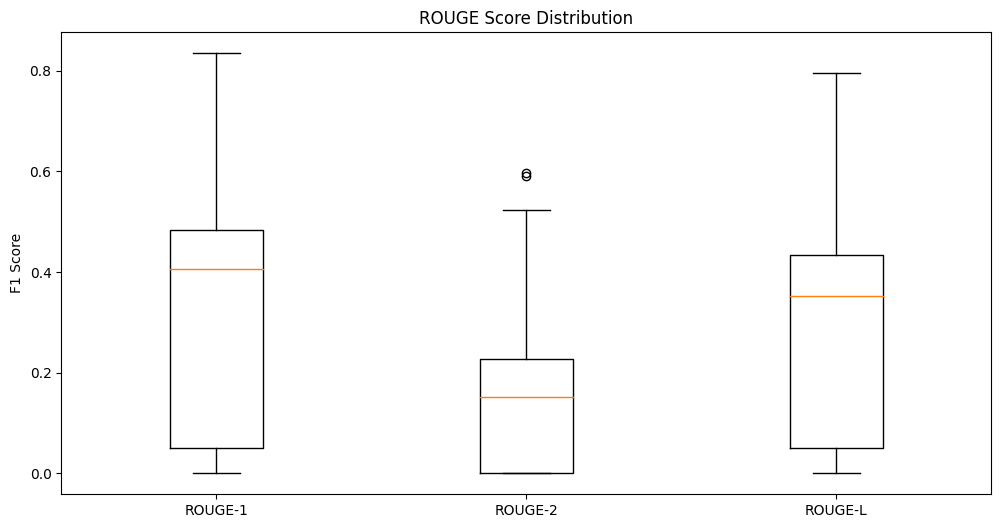

Average ROUGE-1: 0.3336277738464415
Average ROUGE-2: 0.14667775549937062
Average ROUGE-L: 0.2995828122122967


In [19]:
from rouge import Rouge
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

rouge = Rouge()

# Initialize lists to store scores
rouge_1 = []
rouge_2 = []
rouge_l = []

# Generate responses and calculate ROUGE scores iteratively
for question, reference in tqdm(zip(translated_questions, translated_answers), total=len(translated_questions)):
    model_response = generate_response(question)  # Predict response
    if model_response == "":
        rouge_1.append(0)
        rouge_2.append(0)
        rouge_l.append(0)
        continue
    score = rouge.get_scores(model_response, reference, avg=True)  # Calculate ROUGE

    # Extract scores
    rouge_1.append(score['rouge-1']['f'])
    rouge_2.append(score['rouge-2']['f'])
    rouge_l.append(score['rouge-l']['f'])

# Visualize Results
plt.figure(figsize=(12, 6))
plt.boxplot([rouge_1, rouge_2, rouge_l], labels=["ROUGE-1", "ROUGE-2", "ROUGE-L"])
plt.title("ROUGE Score Distribution")
plt.ylabel("F1 Score")
plt.show()

# Print average scores
print("Average ROUGE-1:", np.mean(rouge_1))
print("Average ROUGE-2:", np.mean(rouge_2))
print("Average ROUGE-L:", np.mean(rouge_l))


In [ ]:
REPO_ACCESS_TOKEN = os.getenv("REPO_ACCESS_TOKEN")
MODEL_NAME = "Namronaldo2004/math-vinallama-7b-chat"

bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_use_double_quant = True,
    bnb_4bit_quant_type = "nf4",
    bnb_4bit_compute_dtype = torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map = "auto",
    trust_remote_code = True,
    quantization_config = bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

generation_config = GenerationConfig.from_pretrained(MODEL_NAME)
model.generation_config = generation_config

adapter_config.json:   0%|          | 0.00/796 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/160M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.82k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.67M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/449 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/322 [00:00<?, ?B/s]

In [21]:
# Chatbot
def generate_response(query: str):
    prompt = f"""
    <|im_start|>system
    Bạn là một chuyên gia về toán. Khi nhận được yêu cầu từ người dùng, dựa vào những kiến thức mà bạn đã có, hãy trả lời người dùng một cách nhất quán, đầy đủ nhưng tránh dư thừa thông tin, và hơn hết nội dung câu trả lời phải chính xác nhất
    <|im_end|>
    <|im_start|>user
    ### Yêu cầu:
    {query}
    ### Câu trả lời:
    <|im_end|>
    <|im_start|>assistant
    """.strip()

    device = "cuda" if torch.cuda.is_available() else "cpu"
    encoding = tokenizer(prompt, return_tensors = "pt").to(device)
    with torch.inference_mode():
        outputs = model.generate(
            input_ids = encoding.input_ids,
            attention_mask = encoding.attention_mask,
            generation_config = generation_config,
            max_new_tokens = 150
        )
    
    return tokenizer.decode(outputs[0], skip_special_tokens = True).split("<|im_start|> assistant")[1].strip()

100%|██████████| 1000/1000 [5:40:47<00:00, 20.45s/it] 


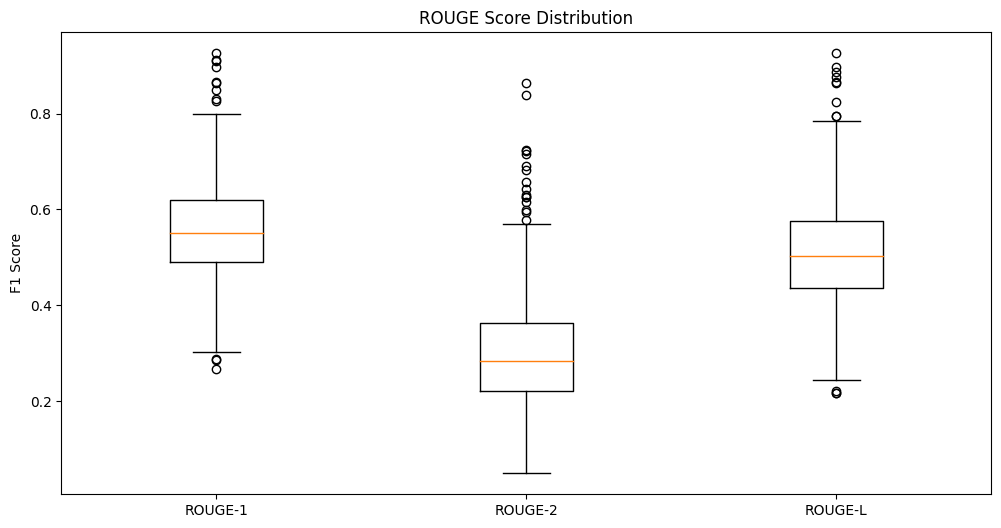

Average ROUGE-1: 0.5570828761313785
Average ROUGE-2: 0.30201642571343085
Average ROUGE-L: 0.5114550544613491


In [22]:
# Initialize lists to store scores
rouge_1 = []
rouge_2 = []
rouge_l = []

# Generate responses and calculate ROUGE scores iteratively
for question, reference in tqdm(zip(translated_questions, translated_answers), total=len(translated_questions)):
    model_response = generate_response(question)  # Predict response
    score = rouge.get_scores(model_response, reference, avg=True)  # Calculate ROUGE

    # Extract scores
    rouge_1.append(score['rouge-1']['f'])
    rouge_2.append(score['rouge-2']['f'])
    rouge_l.append(score['rouge-l']['f'])

# Visualize Results
plt.figure(figsize=(12, 6))
plt.boxplot([rouge_1, rouge_2, rouge_l], labels=["ROUGE-1", "ROUGE-2", "ROUGE-L"])
plt.title("ROUGE Score Distribution")
plt.ylabel("F1 Score")
plt.show()

# Print average scores
print("Average ROUGE-1:", np.mean(rouge_1))
print("Average ROUGE-2:", np.mean(rouge_2))
print("Average ROUGE-L:", np.mean(rouge_l))
